# E20. 시계열 데이터에서 이상치 찾아보기 

## Step 1. 데이터 구하기


주식데이터 :  미국 나스탁 데이터 
- [링크](https://finance.yahoo.com/quote/NQ=F?p=NQ=F)에서 historical data를 눌러보세요.

- Time Period:Sep 18, 2000 - Oct 26, 2020Show:Historical 
- PricesFrequency:Daily

In [32]:
import requests
import os
import copy
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

from statsmodels.stats.weightstats import ztest
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

### Data 불러오기 

In [2]:
csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/NQ=F.csv'

In [3]:
df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0


- Date = 거래날 (string)
- Open = 시가 
- Hign = 고가
- Low = 저가 
- Close = 종가 
- Adj Close = 보정종가 
- Volume = 거래량 

In [4]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date            0
Open         1073
High         1073
Low          1073
Close        1073
Adj Close    1073
Volume       1073
dtype: int64

- 결측치가 각 11개씩 존재하고 있습니다. 
### 결측치 처리 

In [5]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6171
삭제 후 데이터 길이(일자수): 5098


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Step 2. 기본 통계분석으로 이상치 찾기

- 데이터의 분포를 그려보기
- z-test로 정규분포를 만족하는지 확인하기
- (정규분포를 만족하지 않으면) Time series decompose 수행후 residual로 분석하기

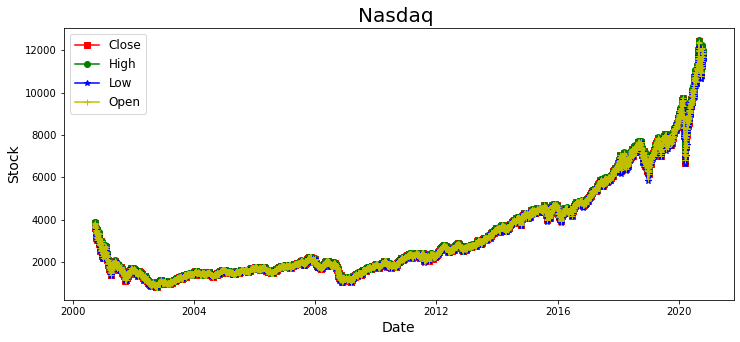

In [6]:
plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('Nasdaq ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

- 이상치Anomailies = 극단치Outlier + 특이치Novelites
- 극단치는 제거해야 모형에 좋습니다.
- 특이치는 남겨둬야 모형에 좋습니다.

#### 정규분포 적용
- 숨어 있는 이상치를 처리하기 위해 정규분포를 적용할 수 있다. 
- 어떤 데이터가 평균과 표준편차로 주어지는 정규분포를 따른다면 아주 높은 확률로 그 데이터는 어떤 신뢰구간 내에 있을 거라고 가정할 수 있으며, 그 **신뢰구간** 밖의 데이터가 나올 확률은 매우 희박해진다면 신뢰구간 밖에 있는 데이터는 이상치라고 생각할 수 있다.


#### 정규분포

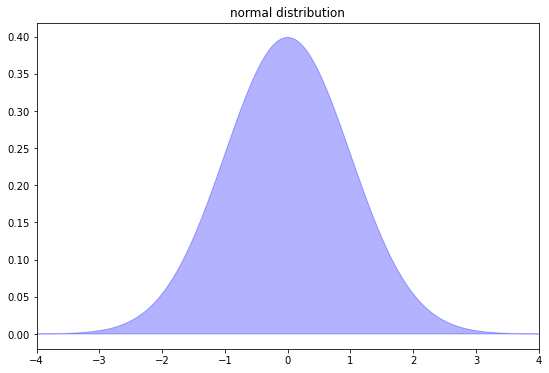

In [7]:
x = np.arange(-6, 6, 0.001)
y = norm.pdf(x,0,1) 
# 평균이 0이고, 표준편차가 1인 정규분포를 그립니다.

# build the plot
fig, ax = plt.subplots(figsize=(9,6))
ax.fill_between(x,y,0, alpha=0.3, color='b')
ax.set_xlim([-4,4])
ax.set_title('normal distribution')
plt.show()


- 이러한 정규분포를 따르는지 확인하는 방법 : z-test
- 시계열 데이터 중에서 정규분포에 가까운 데이터를 뽑아내는 방법 : Time series decomposition

### 정규분포 확인 

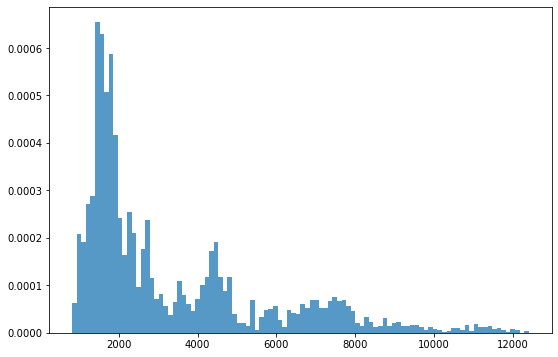

In [8]:
# 그래프로 정규분포 확인, 주식의 종가 
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

- 정규분포와 거리가 멀어 보인다. 

### Z - Test로 확인

In [9]:
# from statsmodels.stats.weightstats import ztest

_, p = ztest(df.Close)
print(p)

0.0


- p가 0.05 이하로 나왔으면 normal distribution과 거리가 멀다는 뜻이에요.
- 이 데이터는 0.0이 나왔네요. 
- 이런 데이터로는 '정규분포'를 가정한 통계적 추정이 어렵다.

### Time series decompose로 확인

> 시계열 데이터 중에서 정규분포에 가까운 데이터를 뽑아내는 방법

- Time series decomposition을 통해 시계열 데이터는 3가지 성분으로 분리되고, 그중 Residual 데이터는 Stationary에 가까운 형태를 가진다.

- 그리고 Stationary에 가까운 데이터는 정규분포를 따른다! 

- 우리는 이 Residual 데이터를 사용해서 신뢰구간을 구할 수 있습니다.
- [Time series decomposition](https://rfriend.tistory.com/510)확인

#### Time series decomposition

- 'additive' 방법과 'multiplicative' 방법이 있어요. 본 예제에서는 additive 방법을 적용해볼께요.

- 간편하게 statsmodel 라이브러리를 이용해서 코스피 종가 데이터를 분석해봅니다.

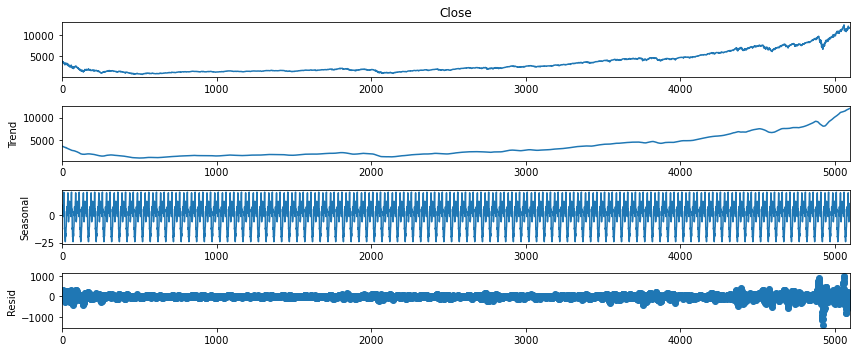

In [10]:
# from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result.plot()
plt.show()

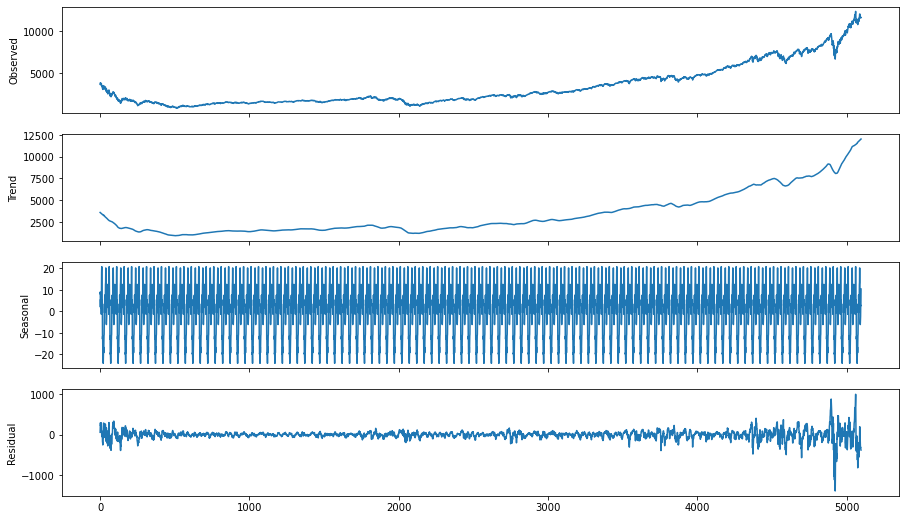

In [11]:
#그래프가 너무 작아서 안보인다면

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(15,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

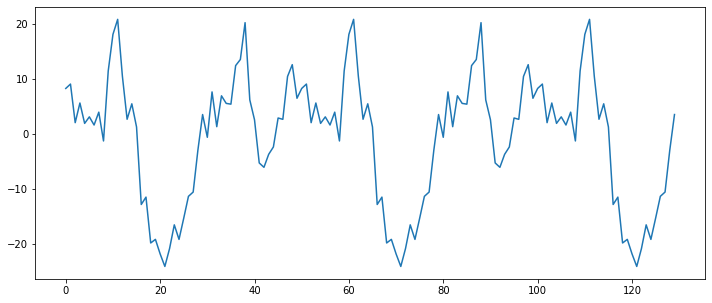

In [12]:
# seasonal 성분은 너무 빼곡하게 보이네요. 다시 확인해보겠습니다.
result.seasonal[:130].plot()

- -20 에서 20 사이를 주기적으로 반복하는게 보이네요.

###  Time series decompose 결과에서 무엇을 알수 있나요?

------

- 정규분포에서 표준편차를 이용한 이상치 인식을 사용하고 싶었어요
- 추세Trend 와 계절적 성분Seasonal을 뽑아내고 남은 잔차Residual를 볼까요?
- 잔차는 평균 0을 기준으로 분포하고 있어요!
- 잔차가 큰 날은 뭔가 일반적인 추세나 계절성에서 벗어난 날로 해석되겠죠?


###  Residual의 분포

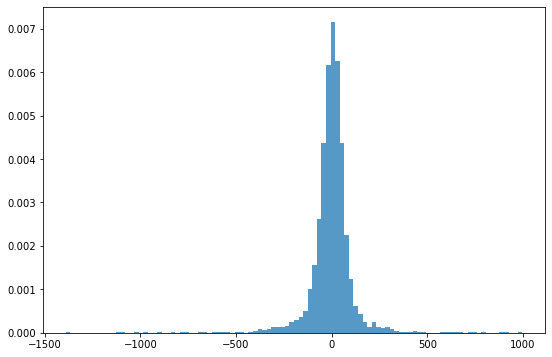

In [13]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

- 그래프는 정규분포를 따른다고 할 수 있는데 첨도가 뾰족!
- 이상치의 분포 범위가 -1500 에서 1000으로  넓어 보인다. 

###  z-test로 residual 확인

In [14]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.8390076883668396 0.40146499522520807


- p-value가 0.04
- 이 정도면 애매한 것 같은데 데이터 분포가 정규분포를 따르고 있다 가정???



### 3σ 기준 신뢰구간으로 이상치 찾기

------
신뢰구간 방법으로 이상치를 탐색하려고 해요. 평균을 기준으로 플러스/마이너스 3σ를 벗어나는 데이터를 찾아봅시다.

In [15]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -1.2913972051412874 표준편차: 109.89901935436704
이상치 갯수: 92


#### +-3σ 기준 / 이상치 범위 날짜 확인

In [16]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

66     2000-12-20
73     2001-01-02
91     2001-01-29
92     2001-01-30
136    2001-04-03
          ...    
5083   2020-10-05
5084   2020-10-06
5085   2020-10-07
5096   2020-10-22
5097   2020-10-23
Name: Date, Length: 92, dtype: datetime64[ns]

### 한 단계 더 나아가기

- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
- 이상치들을 제거/교정해야할지 내버려둘지 고민하기

---
### 해석
- 2000 - 2001년 4월 :: 나스닥 닷컴 버블이 터지면서 붕괴 그 후 주가는 1년이 안되서 반토막 났고, 닷컴 기업들의 파산이 속출 
 
- 2020년 코로나 이후 기세 등등하던 나스닥 대표 IT 기술주들이 주가폭락을 이끌었다. 

- 이런 납득가능한 지표들의 이상치(Anomalies)는 특이치(Novelties)로 구분해 제거하지 않고 분석에 활용한다. 

## Step 3. Unsupervised Clustering 으로 이상치 찾기

- k-means로 분석하기
- DBSCAN으로 분석하기

### 데이터 전처리

------

이번에는 Open, High, Low, Close, Volume 5가지 데이터를 모두 사용

앞서 살펴본 통계방식과 동일하게 Trend/Seasonal 성분을 제거해야 '정말 튀는' 데이터를 찾아낼 수 있어요. 같은 방법으로 **5가지 데이터 모두** time series decompose로 전처리를 해줄께요.

In [17]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,3330.724999,3362.220146,3298.532406,3332.609090,288057.188854
std,2400.892883,2422.863050,2379.665832,2404.825139,109834.091507
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.407500,1597.671250,1571.153750,1584.352001,220586.700000
50%,2264.797500,2292.105000,2232.207500,2265.174199,268932.110000
75%,4434.168125,4466.316875,4401.132500,4435.347500,319674.830000
max,12039.860297,12201.437499,11870.369861,12047.090432,776809.340000


In [18]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,-1.361168,-1.421971,-1.241082,-1.314223,155.136515
std,112.249407,102.051145,116.463672,110.054996,110706.241180
min,-1280.580676,-1494.706438,-1226.976539,-1390.196689,-602731.340129
25%,-38.117788,-35.393102,-38.318769,-37.788724,-53311.671523
50%,3.476876,3.331959,4.089242,2.923191,-488.997470
75%,40.164011,37.638459,41.675332,40.863314,51480.694345
max,996.954616,933.609579,944.823580,996.320780,810713.135421


### 각 변수 표준정규화 

In [19]:
# 표준정규화
# from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.36116811  -1.42197139  -1.24108161  -1.31422283 155.13651478]


array([[ 0.94892246,  0.84646493,  0.81728626,  0.60184276,  0.08322602],
       [ 0.49026957,  1.28420778,  1.38842808,  2.09551792,  0.10454779],
       [ 1.90750707,  2.01838985,  2.0481367 ,  2.7378712 , -0.08888583],
       ...,
       [-2.9355638 , -3.75950684, -2.18973446, -2.93558305,  0.44805172],
       [-3.02900188, -4.45234664, -3.01260131, -3.46542972,  0.39484453],
       [-3.32615554, -5.03188414, -2.82731937, -3.56760069,  0.48127544]])

### k-means 로 이상치 탐색하기

------

우리는 k-means을 이용해서 정상 데이터그룹과 이상치 데이터그룹을 나눠볼꺼에요.

그룹은 2개로 지정

In [20]:
# from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다."

[1 1 1 ... 0 0 0]


In [21]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[1099 3999]


- 어느 한 쪽을 이상치고 정상치로 분류하기엔 서로 양이 너무 많다. 

In [22]:
# 그룹을 25개로 지정 
kmeans = KMeans(n_clusters=25, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:717',
 'group:1-count:26',
 'group:2-count:319',
 'group:3-count:39',
 'group:4-count:492',
 'group:5-count:7',
 'group:6-count:171',
 'group:7-count:13',
 'group:8-count:409',
 'group:9-count:226',
 'group:10-count:839',
 'group:11-count:46',
 'group:12-count:225',
 'group:13-count:13',
 'group:14-count:187',
 'group:15-count:8',
 'group:16-count:103',
 'group:17-count:3',
 'group:18-count:63',
 'group:19-count:483',
 'group:20-count:1',
 'group:21-count:556',
 'group:22-count:115',
 'group:23-count:7',
 'group:24-count:30']

- Group 5, 15, 17, 20, 23 이 count가 10개 이내로 분류된 특이그룹으로 나눌 수 있다. 

**다음 활동을 통해 이상치를 분석해 보겠습니다.**

1. 어떤 날들이 분류된건지
2. 각 그룹은 어떤 특징을 갖고 있는지
3. 왜 이상치로 분류된걸까?

✔️1. 어떤 날들이 분류된건지 (원본 Nasdaq 데이터에서 탐색)

In [23]:
df[(kmeans.labels_==5)|(kmeans.labels_==15)|(kmeans.labels_==17)|(kmeans.labels_==20)|(kmeans.labels_==23)]

,Date,Open,High,Low,Close,Adj Close,Volume
4591,2018-12-26,5902.000000,6310.000000,5820.500000,6285.500000,6285.500000,642440.0
4699,2019-06-03,7110.000000,7132.500000,6941.250000,6993.750000,6993.750000,771723.0
4900,2020-02-23,9355.250000,9365.000000,9289.000000,9315.000000,9315.000000,995989.0
4901,2020-02-24,9355.250000,9365.000000,9041.250000,9091.000000,9091.000000,1171879.0
4916,2020-03-12,7998.750000,8108.000000,7128.500000,7215.250000,7215.250000,876291.0
4917,2020-03-13,7100.000000,7978.000000,6942.500000,7915.750000,7915.750000,584274.0
4918,2020-03-15,7100.000000,7978.000000,6942.500000,7215.250000,7215.250000,578813.0
4919,2020-03-16,7903.000000,7905.250000,6927.000000,7057.500000,7057.500000,307368.0
4920,2020-03-17,7053.000000,7552.250000,6948.750000,7405.250000,7405.250000,317501.0
4921,2020-03-18,7386.000000,7392.250000,6830.000000,7225.250000,7225.250000,156283.0


- 2018년 12월 26일 미국 연방 셧다운 장기화 우려로 주가 폭락 
- 2019년 5월 3일 아마존∙구글 반독점 조사 소식에 혼조 마감
- 2020년 2월 23일 Covid-19로 지속적인 주가 폭락
- 2020년 9월 IT 기술주 (Tsla를 비롯 코로나 이후 폭등한 기술주 이 시기에 폭락)

#### ✔️2. 각 그룹은 어떤 특징을 갖고 있는지


In [24]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,0.093264,0.081487,0.146876,0.123863,-0.470362
1,-3.670336,-3.985607,-3.337972,-3.421617,-0.952478
2,-0.891175,-0.920017,-0.849864,-0.840812,0.247120
3,2.502405,2.523323,2.837353,2.700585,-1.484456
4,0.544449,0.577915,0.502089,0.515205,0.353908
5,-6.088198,-6.160325,-5.748483,-5.122640,1.988784
6,0.406749,0.396601,0.470679,0.451974,-2.049277
7,6.326890,6.428729,6.817048,6.788654,-1.070646
8,-0.326623,-0.339465,-0.383377,-0.373334,0.744510
9,1.104918,1.150308,1.188657,1.179825,-0.419988



- open , High가 유독 낮은 그룹 20

In [25]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000,5.098000e+03
mean,3329.358747,3360.794284,3297.286767,3331.291122,3331.291122,2.882167e+05
std,2400.978546,2422.128357,2380.456260,2404.769584,2404.769584,1.595897e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1593.500000,1608.500000,1576.500000,1593.125000,1593.125000,1.907512e+05
50%,2232.000000,2259.875000,2211.750000,2232.875000,2232.875000,2.657315e+05
75%,4447.000000,4469.875000,4419.437500,4451.187500,4451.187500,3.562115e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


-  나스닥 지수를 보면서 날짜 별로 비교가능 -  https://kr.investing.com/indices/nq-100-advanced-chart

In [26]:
df[(kmeans.labels_==20)]

,Date,Open,High,Low,Close,Adj Close,Volume
4924,2020-03-22,6798.0,6798.0,6628.75,6688.75,6688.75,321230.0



- 2020년 3월 22일은 미국 달력 기준으로 일요일이라 NASDAQ 장이 쉬는 날이라. 
- 이 그룹 데이터는 이상하다고 판단 할 수 있다. 
- 20그룹의 기간인 3월 22일을 기준으로 훑어본다. 

In [27]:
df.iloc[4920:4930]

,Date,Open,High,Low,Close,Adj Close,Volume
4920,2020-03-17,7053.00,7552.25,6948.75,7405.25000,7405.25000,317501.0
4921,2020-03-18,7386.00,7392.25,6830.00,7225.25000,7225.25000,156283.0
4922,2020-03-19,7251.75,7521.50,6894.25,7293.50000,7293.50000,115519.0
4923,2020-03-20,7195.00,7649.00,7153.50,7417.97998,7417.97998,562616.0
4924,2020-03-22,6798.00,6798.00,6628.75,6688.75000,6688.75000,321230.0
4925,2020-03-23,6798.00,7316.25,6628.75,6984.50000,6984.50000,633237.0
4926,2020-03-24,7005.75,7572.25,7005.75,7554.75000,7554.75000,556553.0
4927,2020-03-25,7544.75,7761.00,7371.50,7467.75000,7467.75000,656698.0
4928,2020-03-26,7483.50,7893.50,7310.25,7844.00000,7844.00000,567711.0
4929,2020-03-27,7882.75,7893.25,7551.25,7568.50000,7568.50000,443315.0


- 3월 21일은 토요일 , 3월 22일은 일요일임으로 두 날은 없어야 마땅하다. 
- 그레서 이 데이터는 이상치로 여기고 제거하기로 한다. 
- investing.com 에서도 확인한 결과 3월 22일 거래일은 없다. 

In [28]:
# 4924 번 2020 3월 22일  제거 
df = df.drop([4924])

### DBSCAN 로 이상치 탐색하기

------

DBSCAN 알고리즘은 핵심벡터와 일정 거리 
ϵ
 이내인 데이터 벡터들이 군집(Cluster)을 이루게 하는데, 그러한 군집들과 거리상 동떨어져 군집에 들지 못하는 특이한 데이터들을 노이즈(Noise) 벡터라고 부릅니다.
DBSCAN을 통해 이상치를 찾는 것은 바로 이러한 노이즈 벡터를 찾는 것

In [29]:
# from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.5, min_samples=6).fit(norm_rdf)
clustering

DBSCAN(min_samples=6)

In [30]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

[ 0  0  1 ... -1 -1 -1]


In [31]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:486',
 'group:0-count:4585',
 'group:1-count:22',
 'group:2-count:5']

- DBSCAN 은 그룹 1 - 22개 , 그룹 2 - 5개 소수그룹을 분류했다. 

## Auto-Encoder 로 이상치 탐색하기

------

- 오토인코더는 인코더와 디코더로 구성됩니다.
- 인코더는 입력데이터로부터 중요한 정보(Compressed Feature Vector)를 뽑아냅니다
- 이 과정에서 입력데이터보다 압축된 형태의 데이터를 얻습니다.
- 디코더는 중요한 정보로 입력데이터와 유사한 형태를 재생성(Generate)합니다.
- 인코더가 중요한 정보를 '잘'뽑아내면, 디코더는 입력데이터를 거의 똑같이 생성해낼수 있다.


#### 딥러닝 이상치 탐색의 장점
1. Time series decompostion 없이 분석 수행이 가능하다
2. Trend, Seasonal 데이터를 포함하고 있기 때문에 Trend, Seasonal의 변화도 이상치로써 탐색이 가능하다.

#### 딥러닝 이상치 탐색의 단점
1. 분석자의 주관이 어느정도 필요하긴 하다 (Threshold, window)
2. 학습에 활용할 만큼 충분한 데이터가 확보되어야한다.

본 예제는 keras 공식 예제를 재가공 했습니다

In [35]:
# 필요한 라이브러리를 불러옵니다

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [34]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

### LSTM 을 이용한 오토인코더 모델 만들기

---

##### 데이터 전처리

- 입력 변수를 정규화시켜줘야 딥러닝 모델 학습이 원활합니다
- 가장 일반적인 표준정규분포로 전처리해요

In [36]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

##### keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다
- data : 입력데이터(x)를 넣어줍니다. 우리는 'Open','High','Low','Close','Volume' 5가지 인풋을 사용합니다.

- targets : 출력데이터를 넣어줍니다. 우리는 5가지 인풋 그대로 예측하기 때문에 data와 동일한걸 넣어줍니다.

- length : 몇개의 time_step을 참고할지 입력합니다.

- stride : time_step 사이즈를 결정합니다.

더 자세히 알고 싶다면 [텐서플로우 공식 문서](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator)!!

In [38]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


#### 모델 만들기
- 2개 층의 LSTM으로 인코더를 만듭니다
- RepeatVector는 input을 window_size 만큼 복사해줍니다.

In [43]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 64)            17920     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [44]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [45]:
lstm_hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
159/159 [==============================] - ETA: 0s - loss: 1.0930 - mae: 1.0930
Epoch 00001: val_loss improved from inf to 1.25179, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 5s 30ms/step - loss: 1.0930 - mae: 1.0930 - val_loss: 1.2518 - val_mae: 1.2518
Epoch 2/50
159/159 [==============================] - ETA: 0s - loss: 0.7000 - mae: 0.7000
Epoch 00002: val_loss improved from 1.25179 to 0.64296, saving model to /home/aiffel0042/aiffel/anomaly_detection/kospi/mymodel.ckpt
159/159 [==============================] - 4s 28ms/step - loss: 0.7000 - mae: 0.7000 - val_loss: 0.6430 - val_mae: 0.6430
Epoch 3/50
158/159 [============================>.] - ETA: 0s - loss: 0.4081 - mae: 0.4081
Epoch 00003: val_loss did not improve from 0.64296
159/159 [==============================] - 4s 28ms/step - loss: 0.4072 - mae: 0.4072 - val_loss: 1.2903 - val_mae: 1.2903
Epoch 4/50
158/159 [============================

In [46]:
model.load_weights(checkpoint_path)

### 학습 과정을 확인


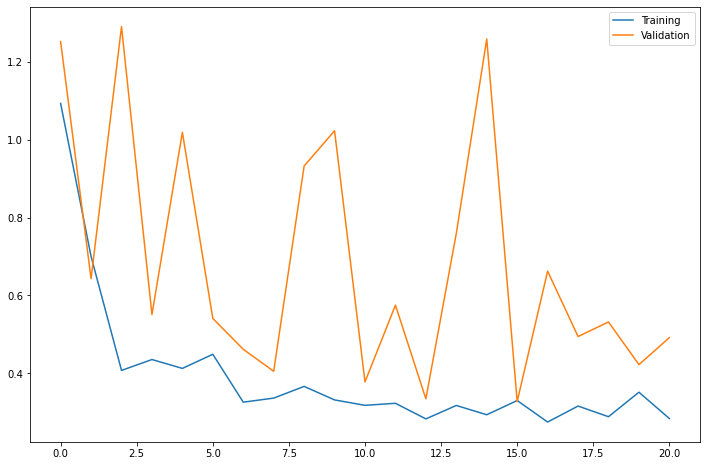

In [48]:
fig = plt.figure(figsize=(12,8))
plt.plot(lstm_hist.history['loss'], label='Training')
plt.plot(lstm_hist.history['val_loss'], label='Validation')
plt.legend()